# 08. 객체탐지 (Object Detection)
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow

## 개념정리


![](https://github.com/yebiny/Image-Segmentation-TF2/blob/main/imgs/seg_type.png?raw=true)

객체 탐지 모델은 여러 분야에서 활용 가능합니다. 가장 대표적인 활용 사례는 자율 주행 자동차입니다. 자율 주행 자동차를 만들기 위해서는 컴퓨터가 스스로 주변 사물을 인식할 수 있어야 합니다. 정지 신호가 있을 때 속도를 줄이고 초록불이 켜지면 다시 주행을 시작하는 등 주변 환경과 상호작용이 필요한 자율 주행 자동차에 객체 탐지 기술이 사용 됩니다.

객체 탐지 기술은 보안 분야에서 효율적인 자원 관리에도 사용됩니다. 일반적으로 CCTV는 쉬지 않고 기록이 되기 때문에 방대한 양의 메모리가 필요합니다. 허나 객체 탐지 기술과 결합하여 특정 사물이 탐지 되었을 때만 기록을 시작하면 메모리를 효율적으로 사용할 수 있습니다.

이번 장에서는 마스크를 탐지하는 객체 탐지 모델을 구축해보겠습니다. 주어진 이미지를 입력을 받았을 때 얼굴 위치를 탐지하고, 얼굴에 마스크가 씌여져 있는지를 확인하는 모델을 구축해볼 것입니다. 

마스크 탐지 모델을 만들기 전에 다양한 탐지 모델을 사용해 보도록 합니다. 

---
### **모델 구조**
---

![](https://lilianweng.github.io/lil-log/assets/images/yolo-network-architecture.png)


위 그림은 객체 탐지 모델 중 가장 유명한 YOLO(You only look once) 모델을 간단히 그린 것입니다. 일반적으로 객체 탐지 모델은 이미지가 인풋으로 들어오면 바운딩 박스의 각 좌표 값과 정확도(score), 그리고 어떤 클래스에 속하는지에 대한 정보를 아웃풋 합니다.

---
### **Bounding Box**
---

출처: https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/object-detection/Ch1-Object-Detection.ipynb#scrollTo=lGyRmZ_OmTg7


객체 탐지 모델을 만들기에 앞서, 우선시 되어야 할 과정은 바운딩 박스를 만드는 것 입니다. 객체 탐지 모델에 사용되는 데이터의 크기가 방대하기 때문에, 바운딩 박스를 통하여 객체를 올바르게 탐지하고 딥러닝 과정에서 바운딩 박스 영역만 대상이 되기 때문에, 딥러닝을 효율적으로 수행할 수 있습니다. 

바운딩 박스는 특정 사물을 탐지하여 모델을 효율적으로 학습 할 수 있도록 도움을 주는 방법입니다. 객체 탐지 모델에서 바운딩 박스는 타겟 위치를 특정하기 위해 사용됩니다. 타겟 위치를 X와 Y축을 이용하여 사각형으로 표현합니다. 예를 들어, 바운딩 박스 값은 (X 최소값, Y 최소값, X 최대값, Y 최대값)으로 표현이 됩니다.

![](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/bc1.PNG)
- 그림 1-2 바운딩 영역 픽셀값으로 지정 (출처: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)

그림 1-2와 같이 X와 Y의 최소값과 최대값 사이의 면적을 바운딩 박스 영역으로 잡습니다. 하지만, 위의 X, Y 값은 픽셀값으로 효율적인 연산을 위해서는 최대값 1로 변환을 해줘야 합니다.

![](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/bc2.PNG)
- 그림 1-3 바운딩 영역 백분위로 지정 (출처: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/raw/master/img/bc2.PNG)

그림 1-3의 X, Y 값은 각각 X의 최대값 971, Y의 최대값 547을 나눈 값입니다. X의 최소값은 640에서 971을 나누면 0.66이 되는 것입니다. 이렇게 분수화는 효율적인 연산을 위한 과정이라고 볼 수 있지만, 필수적인 과정은 아닙니다.


---
### **IOU (Intersection over union)**
---

* 실제값과 예측값이 얼마나 유사한지를 나타내는 지표
  * Area of overlap : 실제값과 예측값이 겹치는 영역
  * Area of Union : 실제값과 예측값의 전체 영역
* IOU 는 전체 영역 중 실제값과 예측값이 겹치는 영역입니다.
* IOU가 높을 수록 잘 예측한 모델이라고 할 수 있습니다.

![](https://t1.daumcdn.net/cfile/tistory/994889425D14A35816)

---
### **NMS (Non-Maximum Suppression, 비최대값 억제)**
---

확률이 가장 높은 상자와 겹치는 상자들을 제거하는 과정입니다. 
* 과정
  * 확률 기준으로 모든 상자를정렬하고 가장 확률이 높은 상자를 취한다.
  * 각 상자에 대해 다른 모든 상자와의 IOU 계산
  * IOU 값이 임계값을 넘는 상자는 제거

## 실습

---
###  **face recognition 라이브러리를 이용한 얼굴탐지**
---

이미지 처리, 선형대수 뿐만 아니라 다양한 머신러닝 알고리즘을 활용할 수 있는 dlib 라이브러리는 C++로 작성된 툴킷이지만, python 패키지로도 설치해 사용할 수 있습니다.

이번시간에는 HOG(Histogram of Oriented Gradients) 특성을 사용하여 얼굴 검출하는 기능을 사용해 보도록 하겠습니다.

https://face-recognition.readthedocs.io/en/latest/readme.html#features

```
! pip install face_recognition
```

In [ ]:
! pip install face_recognition

     |████████████████████████████████| 100.1 MB 22 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=d8310a9b2fcfa107790a7a80af4318fecfd88a14e6c2ed1cf7bbfb226d10ab16
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


#### **모델**
----

In [ ]:
import face_recognition as fr

In [ ]:
img_path = 'mask1.jpg'
img = fr.load_image_file(img_path)
pred = fr.face_locations(img)
print(pred)

[]


#### **추론**
* 결과 pred

  * (y1, x2, y2, x1)

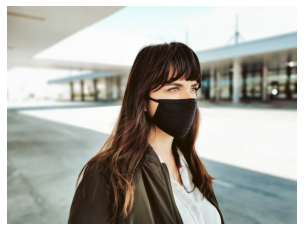

In [ ]:
for (y1,x2,y2,x1) in pred:
  cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)

plt.imshow(img)
plt.axis('off')
plt.show()

---
### **학습되어 있는 모델 가져와 사용하기**
---


```
! git clone https://github.com/yebiny/Face-detection-for-DSM.git
```

In [ ]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

Cloning into 'Face-detection-for-DSM'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 52 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), done.


#### **모델** 
---

* 모델 가져오기

In [ ]:
model_dir =  '/content/Face-detection-for-DSM/models'
facenet = cv2.dnn.readNet(model_dir+'/deploy.prototxt',
                          model_dir+'/res10_300x300_ssd_iter_140000.caffemodel')
                          


#### **이미지 준비**
---

* 이미지 로드

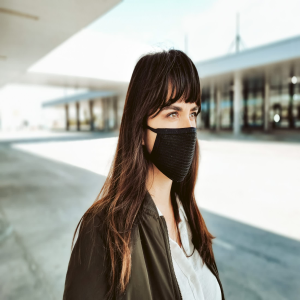

In [ ]:
img_path ='mask1.jpg'
img =cv2.imread(img_path)
img = cv2.resize(img,dsize=(300,300),interpolation = cv2.INTER_AREA)
cv2_imshow(img)
h, w ,_ = img.shape

#### **추론**
---




* `blobFromImage`
```
cv2.dnn.blobFromImage(image, scalefactor=None, 
size=None, 
mean=None, 
swapRB=None, 
crop=None, 
ddepth=None)
```

* 아웃풋
```
( , , 확률, x1, y1, x2, y2)
```

In [ ]:
img_blob = cv2.dnn.blobFromImage(img,scalefactor=1.0 ,size =(300,300))
facenet.setInput(img_blob)
preds = facenet.forward()[0][0]
print(preds.shape)

(200, 7)


* 시각화


0.0 149 77 201 166


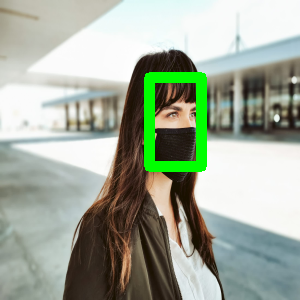

In [ ]:
thres =0.5
for i in range(len(preds)):
  conf = preds[i,2]
  if conf <thres:
    continue
  x1= int(preds[i,3]*h)
  y1= int(preds[i,4]*w)
  x2= int(preds[i,5]*h)
  y2= int(preds[i,6]*w)

print(conf, x1,y1,x2,y2)
cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),10)
cv2_imshow(img)

---
### **Tensorflow Hub 를 이용한 객체탐지**
---

https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb

#### **모델** 
---

* 모델 가져오기

'https://tfhub.dev/tensorflow/efficientdet/d0/1'

In [ ]:
import tensorflow_hub as hub
model=hub.load('https://tfhub.dev/tensorflow/efficientdet/d0/1')

#### **이미지 준비**
---

* 이미지 로드

(640, 960, 3)

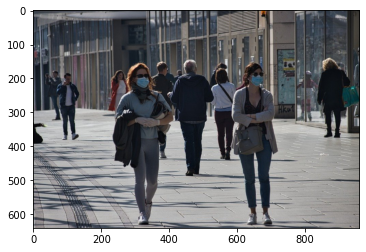

In [ ]:
img_path = 'street0.jpg'
img = plt.imread(img_path)
plt.imshow(img)
img.shape

#### **추론**
---

In [ ]:
preds = model(np.expand_dims(img,0))

In [ ]:
preds.keys()

dict_keys(['raw_detection_scores', 'raw_detection_boxes', 'detection_anchor_indices', 'detection_boxes', 'detection_multiclass_scores', 'num_detections', 'detection_scores', 'detection_classes'])

* 추론 시각화
(y1,x1,y2,x2)

(100,) (100, 4) (100,)
tf.Tensor(0.89823294, shape=(), dtype=float32) 405 143 527 486
1
tf.Tensor(0.8591393, shape=(), dtype=float32) 234 172 404 629
1
tf.Tensor(0.80994934, shape=(), dtype=float32) 68 182 134 383
1
tf.Tensor(0.80002284, shape=(), dtype=float32) 831 138 928 376
1
tf.Tensor(0.719091, shape=(), dtype=float32) 580 161 723 629
1
tf.Tensor(0.666921, shape=(), dtype=float32) 223 177 278 300
1
tf.Tensor(0.6398257, shape=(), dtype=float32) 348 151 414 310
1
tf.Tensor(0.5924002, shape=(), dtype=float32) 517 166 594 442
1
tf.Tensor(0.51851726, shape=(), dtype=float32) 597 329 678 424
31
tf.Tensor(0.51421106, shape=(), dtype=float32) 904 166 958 288
31
tf.Tensor(0.51373285, shape=(), dtype=float32) 775 176 833 330
1


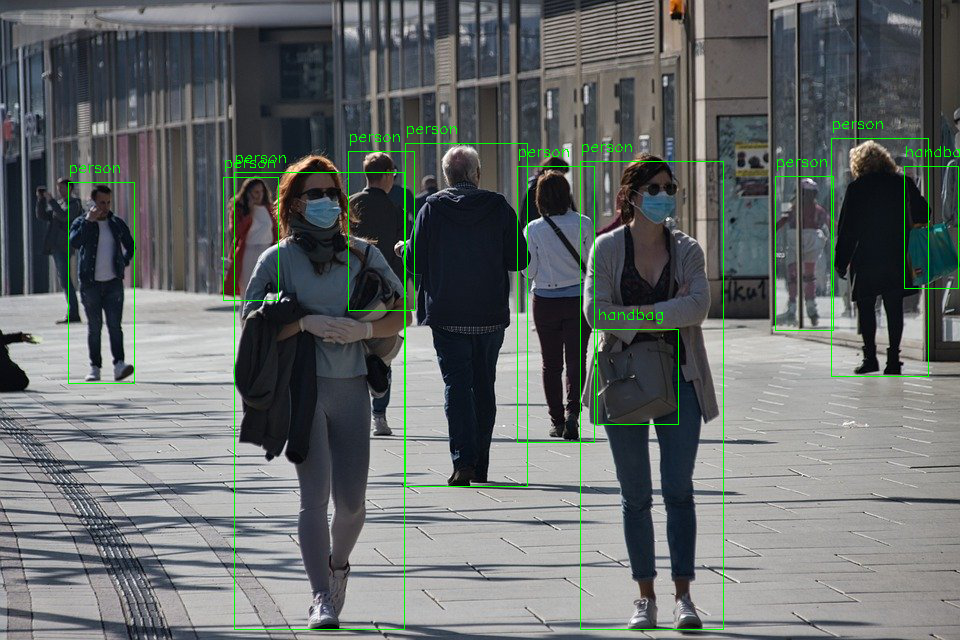

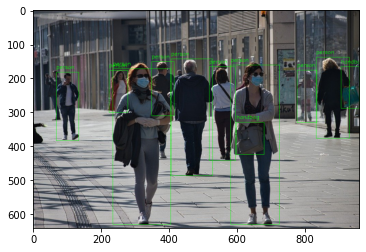

In [ ]:
confs = preds['detection_scores'][0]
boxes = preds['detection_boxes'][0]
classes = preds['detection_classes'][0]
print(confs.shape ,boxes.shape, classes.shape)
h, w ,_ = img.shape

thres =0.5
for i in range(len(confs)):
  conf = confs[i]
  if conf < thres:
    continue
  y1 = int(boxes[i][0]*h)
  x1 = int(boxes[i][1]*w)
  y2 = int(boxes[i][2]*h)
  x2 = int(boxes[i][3]*w)
  print(conf,x1,y1,x2,y2)

  label =int(classes[i])
  print(label)
  txt = LABELS[label]['name']
  cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),1)
  cv2.putText(img,txt,(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),1)
plt.imshow(img)
cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

#### **라벨링**
----

* 데이터 라벨값

```
LABELS = {1: {'id': 1, 'name': 'person'},
          2: {'id': 2, 'name': 'bicycle'},
          3: {'id': 3, 'name': 'car'},
          4: {'id': 4, 'name': 'motorcycle'},
          5: {'id': 5, 'name': 'airplane'},
          6: {'id': 6, 'name': 'bus'},
          7: {'id': 7, 'name': 'train'},
          8: {'id': 8, 'name': 'truck'},
          9: {'id': 9, 'name': 'boat'},
          10: {'id': 10, 'name': 'traffic light'},
          11: {'id': 11, 'name': 'fire hydrant'},
          13: {'id': 13, 'name': 'stop sign'},
          14: {'id': 14, 'name': 'parking meter'},
          15: {'id': 15, 'name': 'bench'},
          16: {'id': 16, 'name': 'bird'},
          17: {'id': 17, 'name': 'cat'},
          18: {'id': 18, 'name': 'dog'},
          19: {'id': 19, 'name': 'horse'},
          20: {'id': 20, 'name': 'sheep'},
          21: {'id': 21, 'name': 'cow'},
          22: {'id': 22, 'name': 'elephant'},
          23: {'id': 23, 'name': 'bear'},
          24: {'id': 24, 'name': 'zebra'},
          25: {'id': 25, 'name': 'giraffe'},
          27: {'id': 27, 'name': 'backpack'},
          28: {'id': 28, 'name': 'umbrella'},
          31: {'id': 31, 'name': 'handbag'},
          32: {'id': 32, 'name': 'tie'},
          33: {'id': 33, 'name': 'suitcase'},
          34: {'id': 34, 'name': 'frisbee'},
          35: {'id': 35, 'name': 'skis'},
          36: {'id': 36, 'name': 'snowboard'},
          37: {'id': 37, 'name': 'sports ball'},
          38: {'id': 38, 'name': 'kite'},
          39: {'id': 39, 'name': 'baseball bat'},
          40: {'id': 40, 'name': 'baseball glove'},
          41: {'id': 41, 'name': 'skateboard'},
          42: {'id': 42, 'name': 'surfboard'},
          43: {'id': 43, 'name': 'tennis racket'},
          44: {'id': 44, 'name': 'bottle'},
          46: {'id': 46, 'name': 'wine glass'},
          47: {'id': 47, 'name': 'cup'},
          48: {'id': 48, 'name': 'fork'},
          49: {'id': 49, 'name': 'knife'},
          50: {'id': 50, 'name': 'spoon'},
          51: {'id': 51, 'name': 'bowl'},
          52: {'id': 52, 'name': 'banana'},
          53: {'id': 53, 'name': 'apple'},
          54: {'id': 54, 'name': 'sandwich'},
          55: {'id': 55, 'name': 'orange'},
          56: {'id': 56, 'name': 'broccoli'},
          57: {'id': 57, 'name': 'carrot'},
          58: {'id': 58, 'name': 'hot dog'},
          59: {'id': 59, 'name': 'pizza'},
          60: {'id': 60, 'name': 'donut'},
          61: {'id': 61, 'name': 'cake'},
          62: {'id': 62, 'name': 'chair'},
          63: {'id': 63, 'name': 'couch'},
          64: {'id': 64, 'name': 'potted plant'},
          65: {'id': 65, 'name': 'bed'},
          67: {'id': 67, 'name': 'dining table'},
          70: {'id': 70, 'name': 'toilet'},
          72: {'id': 72, 'name': 'tv'},
          73: {'id': 73, 'name': 'laptop'},
          74: {'id': 74, 'name': 'mouse'},
          75: {'id': 75, 'name': 'remote'},
          76: {'id': 76, 'name': 'keyboard'},
          77: {'id': 77, 'name': 'cell phone'},
          78: {'id': 78, 'name': 'microwave'},
          79: {'id': 79, 'name': 'oven'},
          80: {'id': 80, 'name': 'toaster'},
          81: {'id': 81, 'name': 'sink'},
          82: {'id': 82, 'name': 'refrigerator'},
          84: {'id': 84, 'name': 'book'},
          85: {'id': 85, 'name': 'clock'},
          86: {'id': 86, 'name': 'vase'},
          87: {'id': 87, 'name': 'scissors'},
          88: {'id': 88, 'name': 'teddy bear'},
          89: {'id': 89, 'name': 'hair drier'},
          90: {'id': 90, 'name': 'toothbrush'}}
 ```

In [ ]:
LABELS = {1: {'id': 1, 'name': 'person'},
          2: {'id': 2, 'name': 'bicycle'},
          3: {'id': 3, 'name': 'car'},
          4: {'id': 4, 'name': 'motorcycle'},
          5: {'id': 5, 'name': 'airplane'},
          6: {'id': 6, 'name': 'bus'},
          7: {'id': 7, 'name': 'train'},
          8: {'id': 8, 'name': 'truck'},
          9: {'id': 9, 'name': 'boat'},
          10: {'id': 10, 'name': 'traffic light'},
          11: {'id': 11, 'name': 'fire hydrant'},
          13: {'id': 13, 'name': 'stop sign'},
          14: {'id': 14, 'name': 'parking meter'},
          15: {'id': 15, 'name': 'bench'},
          16: {'id': 16, 'name': 'bird'},
          17: {'id': 17, 'name': 'cat'},
          18: {'id': 18, 'name': 'dog'},
          19: {'id': 19, 'name': 'horse'},
          20: {'id': 20, 'name': 'sheep'},
          21: {'id': 21, 'name': 'cow'},
          22: {'id': 22, 'name': 'elephant'},
          23: {'id': 23, 'name': 'bear'},
          24: {'id': 24, 'name': 'zebra'},
          25: {'id': 25, 'name': 'giraffe'},
          27: {'id': 27, 'name': 'backpack'},
          28: {'id': 28, 'name': 'umbrella'},
          31: {'id': 31, 'name': 'handbag'},
          32: {'id': 32, 'name': 'tie'},
          33: {'id': 33, 'name': 'suitcase'},
          34: {'id': 34, 'name': 'frisbee'},
          35: {'id': 35, 'name': 'skis'},
          36: {'id': 36, 'name': 'snowboard'},
          37: {'id': 37, 'name': 'sports ball'},
          38: {'id': 38, 'name': 'kite'},
          39: {'id': 39, 'name': 'baseball bat'},
          40: {'id': 40, 'name': 'baseball glove'},
          41: {'id': 41, 'name': 'skateboard'},
          42: {'id': 42, 'name': 'surfboard'},
          43: {'id': 43, 'name': 'tennis racket'},
          44: {'id': 44, 'name': 'bottle'},
          46: {'id': 46, 'name': 'wine glass'},
          47: {'id': 47, 'name': 'cup'},
          48: {'id': 48, 'name': 'fork'},
          49: {'id': 49, 'name': 'knife'},
          50: {'id': 50, 'name': 'spoon'},
          51: {'id': 51, 'name': 'bowl'},
          52: {'id': 52, 'name': 'banana'},
          53: {'id': 53, 'name': 'apple'},
          54: {'id': 54, 'name': 'sandwich'},
          55: {'id': 55, 'name': 'orange'},
          56: {'id': 56, 'name': 'broccoli'},
          57: {'id': 57, 'name': 'carrot'},
          58: {'id': 58, 'name': 'hot dog'},
          59: {'id': 59, 'name': 'pizza'},
          60: {'id': 60, 'name': 'donut'},
          61: {'id': 61, 'name': 'cake'},
          62: {'id': 62, 'name': 'chair'},
          63: {'id': 63, 'name': 'couch'},
          64: {'id': 64, 'name': 'potted plant'},
          65: {'id': 65, 'name': 'bed'},
          67: {'id': 67, 'name': 'dining table'},
          70: {'id': 70, 'name': 'toilet'},
          72: {'id': 72, 'name': 'tv'},
          73: {'id': 73, 'name': 'laptop'},
          74: {'id': 74, 'name': 'mouse'},
          75: {'id': 75, 'name': 'remote'},
          76: {'id': 76, 'name': 'keyboard'},
          77: {'id': 77, 'name': 'cell phone'},
          78: {'id': 78, 'name': 'microwave'},
          79: {'id': 79, 'name': 'oven'},
          80: {'id': 80, 'name': 'toaster'},
          81: {'id': 81, 'name': 'sink'},
          82: {'id': 82, 'name': 'refrigerator'},
          84: {'id': 84, 'name': 'book'},
          85: {'id': 85, 'name': 'clock'},
          86: {'id': 86, 'name': 'vase'},
          87: {'id': 87, 'name': 'scissors'},
          88: {'id': 88, 'name': 'teddy bear'},
          89: {'id': 89, 'name': 'hair drier'},
          90: {'id': 90, 'name': 'toothbrush'}}

* 색상

#### **플로우 정리**
---